In [1]:
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Lambda,Embedding,GRU,TimeDistributed,RepeatVector,Merge,BatchNormalization,Input,merge,UpSampling2D,Convolution2D,UpSampling1D,Convolution1D

from keras.preprocessing import sequence
from keras import callbacks
from keras.optimizers import SGD, RMSprop, Adam

import numpy as np
from vgg16 import Vgg16
import matplotlib.pyplot as plt
import PIL.Image

from tqdm import tqdm

from utils import *

import cPickle as pickle
import string

import collections
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import re
from numpy.random import random, permutation, randn, normal 

import os

import preprocessing as preproc


from keras import backend as K

Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

def create_emb(vecs,words,wordidx,vocab_size):
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    found = 0
    not_found = 0
    
    exclude = set(string.punctuation)
    for i in range(1,len(emb)):
        word = index2word[i]
        word = ''.join(ch for ch in word if ch not in exclude).lower()
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word) and word in wordidx:
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
            found +=1
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))
            not_found+=1
#             print(word)

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    
    print("Found = %d"%found)
    print("Not found = %d"%not_found)
        
    return emb

def get_emb_for_word_word(word,vecs,wordidx):
    n_fact = vecs.shape[1]
        
    exclude = set(string.punctuation)
    word = ''.join(ch for ch in word if ch not in exclude).lower()
    if word and re.match(r"^[a-zA-Z0-9\-]*$", word) and word in wordidx:
        src_idx = wordidx[word]
        return vecs[src_idx]
    else:
        return normal(scale=0.6, size=(n_fact,))

    
    return emb


In [3]:
base_path = app_3_length_15_data_path

train_path = base_path + train_folder
val_path = base_path + val_folder

In [4]:
unique_words = preproc.load_obj(base_path + general_datastruct_folder+"unique_words")
word2index = preproc.load_obj(base_path+general_datastruct_folder+"word2index")
index2word = preproc.load_obj(base_path+general_datastruct_folder+"index2word")
VOCAB_SIZE = len(unique_words)
MAX_CAPTION_LEN = 15
print(VOCAB_SIZE)

7275


# Images

In [5]:
images_concat_t = preproc.read_serialized_np_arr(val_path + images_concat_folder+ 'images_concat.bc')[:1000]

In [6]:
print(images_concat_t.shape)

(1000, 3, 224, 224)


# Captions

In [7]:
captions_indexed = load_array(val_path + indexed_captions_folder + "indexed_captions.bc")[:1000,:10]

In [9]:
print(captions_indexed.shape)

(1000, 10)


# Word embeddings

In [10]:
EMB_SIZE = 200
vecs, words, wordidx = load_vectors(save_path+glove_folder+"6B."+str(EMB_SIZE)+"d")


In [12]:
captions_embedded = np.zeros((1000,10,200))

for c_index in tqdm((range(len(captions_indexed)))):

    caption_indexed = captions_indexed[c_index]
                          
    for w_index in range(len(caption_indexed)):
        word_index = caption_indexed[w_index]
        
        word_embedding = get_emb_for_word_word(index2word[word_index],vecs,wordidx)
        
        captions_embedded[c_index,w_index] = word_embedding
    


100%|██████████| 1000/1000 [00:00<00:00, 7458.45it/s]


In [13]:
captions_embedded.shape

(1000, 10, 200)

# NN Definition

In [27]:
# upscaling_factor = 2

model = Sequential()
model.add(UpSampling1D(10, input_shape = (10,200)))
model.add(UpSampling1D(10))
model.add(UpSampling1D(10))
model.add(Convolution1D(3, 1,activation='softmax'))

model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
upsampling1d_13 (UpSampling1D)   (None, 100, 200)      0           upsampling1d_input_4[0][0]       
____________________________________________________________________________________________________
upsampling1d_14 (UpSampling1D)   (None, 1000, 200)     0           upsampling1d_13[0][0]            
____________________________________________________________________________________________________
upsampling1d_15 (UpSampling1D)   (None, 10000, 200)    0           upsampling1d_14[0][0]            
____________________________________________________________________________________________________
convolution1d_4 (Convolution1D)  (None, 10000, 3)      603         upsampling1d_15[0][0]            
Total params: 603
Trainable params: 603
Non-trainable params: 0
___________________________

In [31]:
images_trunc = images_concat_t[:,:,:100,:100]
images_trunc.shape

(1000, 3, 100, 100)

In [40]:
images_trunc_reshaped = np.transpose(images_trunc.reshape(1000,3,10000),(0,2,1))
print(images_trunc_reshaped.shape)

(1000, 10000, 3)


In [66]:
model.fit(captions_embedded, 
          images_trunc_reshaped, 
          batch_size=64, 
          nb_epoch=15,
         )

Epoch 1/15
1000/1000 [==============================] - 2s - loss: 396.2817 - acc: 0.4470     

In [74]:
test_index= 100

In [75]:
test_caption = np.expand_dims(captions_embedded[test_index],axis=0)
test_caption.shape

(1, 10, 200)

In [76]:
predicted_pic = model.predict(test_caption)
predicted_pic = np.squeeze(predicted_pic)

In [77]:
reshaped_pic = predicted_pic.reshape(100,100,3)
reshaped_pic.shape

(100, 100, 3)

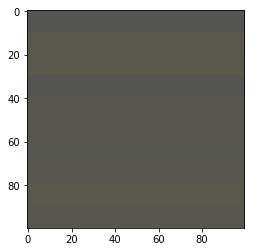

In [78]:
plt.imshow(reshaped_pic)
plt.show()

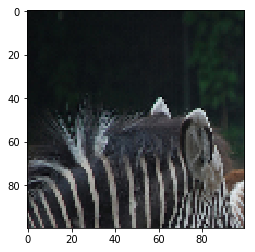

In [80]:
plt.imshow(images_trunc_reshaped[test_index].reshape(100,100,3))
plt.show()